[[0 0 1 0 0]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [0 0 1 0 0]] <class 'numpy.ndarray'>


Text(0.5, 1.0, 'Binar Eroziya')

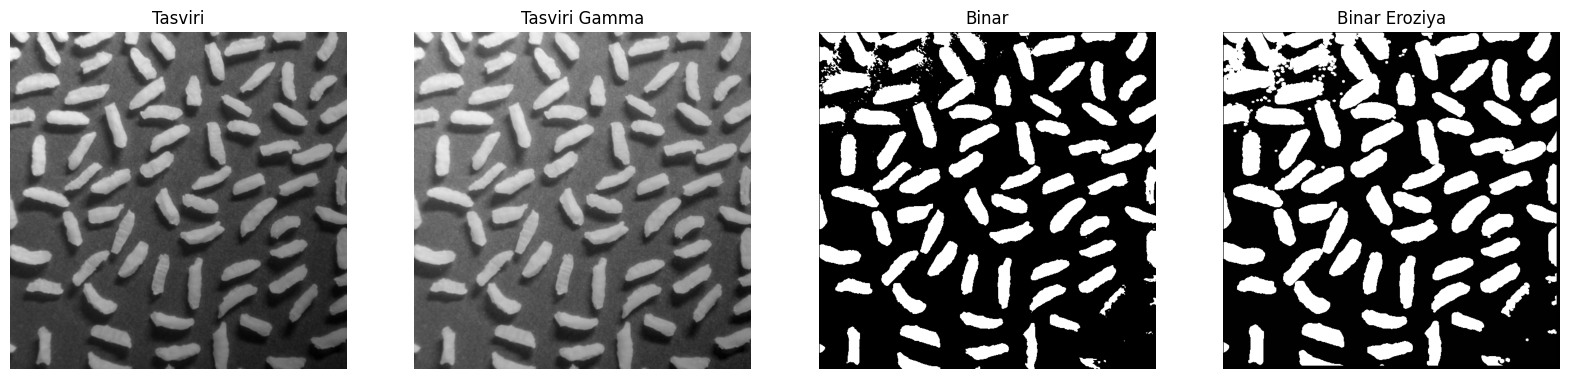

In [5]:
#IMpuls shovqini qo`shish va mediana filrt bilan ishlov berish
import numpy as np
import random
from PIL import Image, ImageDraw #Подключим необходимые библиотеки. 
import math

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np


import cv2 as cv
mu, sigma = 0, 0.1 # mean and standard deviation


f = Image.open("DIP3E_Original_Images_CH09/Fig0940(a)(rice_image_with_intensity_gradient).tif") 
M = f.size[1] #Определяем ширину. 
N = f.size[0] #Определяем высоту. 

fig = plt.figure(figsize=(20, 40))
rows, columns=(1,4)


fimg=f.load()


fig.add_subplot(rows, columns, 1) 
plt.imshow(f, cmap='gray')
plt.axis('off')
plt.title("Tasviri")

c=1;
gamma=0.4;
#pix = image.load() #Выгружаем значения пикселей.
#pix1 = im.load()
#print(type(pix1[1,1]))
for i in range(N):
    for j in range(M):
        #T=c*math.log10(1+pix[i, j])
        T=c*math.pow(fimg[i, j],gamma)/math.pow(255,gamma-1)
        if(T<0):
            fimg[i,j]=int(0)
            
        elif(T>255):
            fimg[i,j]=int(255)
            #print("salom")
            
        else:
            fimg[i,j]=int(T)

fig.add_subplot(rows, columns, 2) 
plt.imshow(f, cmap='gray')
plt.axis('off')
plt.title("Tasviri Gamma")

imgnew  = Image.new( mode = "L", size = (N, M) )

imgnewpix=imgnew.load()

porog=195

for i in range(1,N):
    for j in range(1, M):
        if(fimg[i,j]<porog):
            imgnewpix[i,j]=0;
        else:
            imgnewpix[i,j]=255;



fig.add_subplot(rows, columns, 3) 
plt.imshow(imgnew, cmap='gray')
plt.axis('off')
plt.title("Binar")

Nmax=5



imgnewEro  = Image.new( mode = "L", size = (N, M) )

imgnewpixEro=imgnewEro.load()

noise_image=np.clip(imgnew, 0, 255).astype(np.uint32)

dd=cv.getStructuringElement(cv.MORPH_ELLIPSE,(5,5))


def convolution2d(image, kernel, bias):
    m, n = kernel.shape
    if (m == n):
        y, x = image.shape
        y = y - m + 1
        x = x - m + 1
        new_image = np.zeros((y,x))
        for i in range(y):
            for j in range(x):
                new_image[i][j] = np.sum(image[i:i+m, j:j+m]*kernel) + bias
    return new_image


print(dd, type(dd))
for i in range(1,N-Nmax-1):
    for j in range(1, M-Nmax-1):
        #print(np.array(noise_image[j:j+Nmax,i:i+Nmax]))
        tup=convolution2d(np.array(noise_image[j:j+Nmax,i:i+Nmax]),dd,1)
        ddd=np.min((tup))
        imgnewpixEro[i,j]=int(ddd)

fig.add_subplot(rows, columns, 4) 
plt.imshow(imgnewEro, cmap='gray')
plt.axis('off')
plt.title("Binar Eroziya")

In [6]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Copyright 2012 - 2013
# Matías Herranz <matiasherranz@gmail.com>
# Joaquín Tita <joaquintita@gmail.com>
#
# https://github.com/PyRadar/pyradar
#
# This library is free software; you can redistribute it and/or
# modify it under the terms of the GNU Lesser General Public
# License as published by the Free Software Foundation; either
# version 3 of the License, or (at your option) any later version.
#
# This library is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU
# Lesser General Public License for more details.
#
# You should have received a copy of the GNU Lesser General Public
# License along with this library. If not, see <http://www.gnu.org/licenses/>.


import numpy as np
from scipy.cluster import vq

#from pyradar.utils import take_snapshot


def initialize_parameters(parameters=None):
    """Auxiliar function to set default values to all the parameters not
    given a value by the user.

    """
    parameters = {} if not parameters else parameters

    def safe_pull_value(parameters, key, default):
        return parameters.get(key, default)

    # number of clusters desired
    K = safe_pull_value(parameters, 'K', 5)

    # maximum number of iterations
    I = safe_pull_value(parameters, 'I', 100)

    # maximum of number of pairs of clusters which can be merged
    P = safe_pull_value(parameters, 'P', 4)

    # threshold value for  minimum number of samples in each cluster
    # (discarding clusters)
    THETA_M = safe_pull_value(parameters, 'THETA_M', 10)

    # threshold value for standard deviation (for split)
    THETA_S = safe_pull_value(parameters, 'THETA_S', 1)
    # threshold value for pairwise distances (for merge)
    THETA_C = safe_pull_value(parameters, 'THETA_C', 20)

    # percentage of change in clusters between each iteration
    #(to stop algorithm)
    THETA_O = 0.05

    #can use any of both fixed or random
    # number of starting clusters
    #k = np.random.randint(1, K)
    k = safe_pull_value(parameters, 'k', K)

    ret = locals()
    ret.pop('safe_pull_value')
    ret.pop('parameters')
    globals().update(ret)


def quit_low_change_in_clusters(centers, last_centers, iter):
    """Stop algorithm by low change in the clusters values between each
    iteration.

    :returns: True if should stop, otherwise False.

    """
    quit = False
    if centers.shape == last_centers.shape:
        thresholds = np.abs((centers - last_centers) / (last_centers + 1))

        if np.all(thresholds <= THETA_O):  # percent of change in [0:1]
            quit = True
#            print "Isodata(info): Stopped by low threshold at the centers."
#            print "Iteration step: %s" % iter

    return quit


def merge_clusters(img_class_flat, centers, clusters_list):
    """
    Merge by pair of clusters in 'below_threshold' to form new clusters.
    """
    pair_dists = compute_pairwise_distances(centers)

    first_p_elements = pair_dists[:P]

    below_threshold = [(c1, c2) for d, (c1, c2) in first_p_elements
                                if d < THETA_C]

    if below_threshold:
        k = centers.size
        count_per_cluster = np.zeros(k)
        to_add = np.array([])  # new clusters to add
        to_delete = np.array([])  # clusters to delete

        for cluster in range(0, k):
            result = np.where(img_class_flat == clusters_list[cluster])
            indices = result[0]
            count_per_cluster[cluster] = indices.size

        for c1, c2 in below_threshold:
            c1_count = float(count_per_cluster[c1]) + 1
            c2_count = float(count_per_cluster[c2])
            factor = 1.0 / (c1_count + c2_count)
            weight_c1 = c1_count * centers[c1]
            weight_c2 = c2_count * centers[c2]

            value = round(factor * (weight_c1 + weight_c2))

            to_add = np.append(to_add, value)
            to_delete = np.append(to_delete, [c1, c2])

        #delete old clusters and their indices from the availables array
        centers = np.delete(centers, to_delete)
        clusters_list = np.delete(clusters_list, to_delete)

        #generate new indices for the new clusters
        #starting from the max index 'to_add.size' times
        start = int(clusters_list.max())
        end = to_add.size + start

        centers = np.append(centers, to_add)
        clusters_list = np.append(clusters_list, range(start, end))

        centers, clusters_list = sort_arrays_by_first(centers, clusters_list)

    return centers, clusters_list


def compute_pairwise_distances(centers):
    """
    Compute the pairwise distances 'pair_dists', between every two clusters
    centers and returns them sorted.
    Returns:
           - a list with tuples, where every tuple has in it's first coord the
             distance between to clusters, and in the second coord has a tuple,
             with the numbers of the clusters measured.
             Output example:
                [(d1,(cluster_1,cluster_2)),
                 (d2,(cluster_3,cluster_4)),
                 ...
                 (dn, (cluster_n,cluster_n+1))]
    """
    pair_dists = []
    size = centers.size

    for i in range(0, size):
        for j in range(0, size):
            if i > j:
                d = np.abs(centers[i] - centers[j])
                pair_dists.append((d, (i, j)))

    #return it sorted on the first elem
    return sorted(pair_dists)


def split_clusters(img_flat, img_class_flat, centers, clusters_list):
    """
    Split clusters to form new clusters.
    """
    assert centers.size == clusters_list.size, \
        "ERROR: split() centers and clusters_list size are different"

    delta = 10
    k = centers.size
    count_per_cluster = np.zeros(k)
    stddev = np.array([])

    avg_dists_to_clusters = compute_avg_distance(img_flat, img_class_flat,
                                                 centers, clusters_list)
    d = compute_overall_distance(img_class_flat, avg_dists_to_clusters,
                                 clusters_list)

    # compute all the standard deviation of the clusters
    for cluster in range(0, k):
        indices = np.where(img_class_flat == clusters_list[cluster])[0]
        count_per_cluster[cluster] = indices.size
        value = ((img_flat[indices] - centers[cluster]) ** 2).sum()
        value /= count_per_cluster[cluster]
        value = np.sqrt(value)
        stddev = np.append(stddev, value)

    cluster = stddev.argmax()
    max_stddev = stddev[cluster]
    max_clusters_list = int(clusters_list.max())

    if max_stddev > THETA_S:
        if avg_dists_to_clusters[cluster] >= d:
            if count_per_cluster[cluster] > (2.0 * THETA_M):
                old_cluster = centers[cluster]
                new_cluster_1 = old_cluster + delta
                new_cluster_2 = old_cluster - delta

                centers = np.delete(centers, cluster)
                clusters_list = np.delete(clusters_list, cluster)

                centers = np.append(centers, [new_cluster_1, new_cluster_2])
                clusters_list = np.append(clusters_list, [max_clusters_list,
                                          (max_clusters_list + 1)])

                centers, clusters_list = sort_arrays_by_first(centers,
                                                              clusters_list)

                assert centers.size == clusters_list.size, \
                   "ERROR: split() centers and clusters_list size are different"

    return centers, clusters_list


def compute_overall_distance(img_class_flat, avg_dists_to_clusters,
                             clusters_list):
    """
    Computes the overall distance of the samples from their respective cluster
    centers.
    """
    k = avg_dists_to_clusters.size
    total = img_class_flat.size
    count_per_cluster = np.zeros(k)

    for cluster in range(0, k):
        indices = np.where(img_class_flat == clusters_list[cluster])[0]
        count_per_cluster[cluster] = indices.size

    d = ((count_per_cluster / total) * avg_dists_to_clusters).sum()

    return d


def compute_avg_distance(img_flat, img_class_flat, centers, clusters_list):
    """
    Computes all the average distances to the center in each cluster.
    """
    k = centers.size
    avg_dists_to_clusters = np.array([])

    for cluster in range(0, k):
        indices = np.where(img_class_flat == clusters_list[cluster])[0]

        total_per_cluster = indices.size + 1
        sum_per_cluster = (np.abs(img_flat[indices] - centers[cluster])).sum()

        dj = (sum_per_cluster / float(total_per_cluster))

        avg_dists_to_clusters = np.append(avg_dists_to_clusters, dj)

    return avg_dists_to_clusters


def discard_clusters(img_class_flat, centers, clusters_list):
    """
    Discard clusters with fewer than THETA_M.
    """
    k = centers.shape[0]
    to_delete = np.array([])

    assert centers.size == clusters_list.size, \
        "ERROR: discard_cluster() centers and clusters_list size are different"

    for cluster in range(0, k):
        indices = np.where(img_class_flat == clusters_list[cluster])[0]
        total_per_cluster = indices.size
        if total_per_cluster <= THETA_M:
            to_delete = np.append(to_delete, cluster)

    if to_delete.size:
        new_centers = np.delete(centers, to_delete)
        new_clusters_list = np.delete(clusters_list, to_delete)
    else:
        new_centers = centers
        new_clusters_list = clusters_list

    new_centers, new_clusters_list = sort_arrays_by_first(new_centers,
                                                          new_clusters_list)

#        shape_bef = centers.shape[0]
#        shape_aft = new_centers.shape[0]
#        print "Isodata(info): Discarded %s clusters." % (shape_bef - shape_aft)

#        if to_delete.size:
#            print "Clusters discarded %s" % to_delete

    assert new_centers.size == new_clusters_list.size, \
        "ERROR: discard_cluster() centers and clusters_list size are different"

    return new_centers, new_clusters_list


def update_clusters(img_flat, img_class_flat, centers, clusters_list):
    """ Update clusters. """
    k = centers.shape[0]
    new_centers = np.array([])
    new_clusters_list = np.array([])

    assert centers.size == clusters_list.size, \
        "ERROR: update_clusters() centers and clusters_list size are different"

    for cluster in range(0, k):
        indices = np.where(img_class_flat == clusters_list[cluster])[0]
        #get whole cluster
        cluster_values = img_flat[indices]
        #sum and count the values
        sum_per_cluster = cluster_values.sum()
        total_per_cluster = (cluster_values.size) + 1
        #compute the new center of the cluster
        new_cluster = sum_per_cluster / total_per_cluster

        new_centers = np.append(new_centers, new_cluster)
        new_clusters_list = np.append(new_clusters_list, cluster)

    new_centers, new_clusters_list = sort_arrays_by_first(new_centers,
                                                          new_clusters_list)

    assert new_centers.size == new_clusters_list.size, \
        "ERROR: update_clusters() centers and clusters_list size are different"

    return new_centers, new_clusters_list


def initial_clusters(img_flat, k, method="linspace"):
    """
    Define initial clusters centers as startup.
    By default, the method is "linspace". Other method available is "random".
    """
    methods_availables = ["linspace", "random"]

    assert method in methods_availables, "ERROR: method %s is no valid." \
                                         "Methods availables %s" \
                                         % (method, methods_availables)
    if method == "linspace":
        max, min = img_flat.max(), img_flat.min()
        centers = np.linspace(min, max, k)
    elif method == "random":
        start, end = 0, img_flat.size
        indices = np.random.randint(start, end, k)
        centers = img_flat.take(indices)

    return centers


def sort_arrays_by_first(centers, clusters_list):
    """
    Sort the array 'centers' and the with indices of the sorted centers
    order the array 'clusters_list'.
    Example: centers=[22, 33, 0, 11] and cluster_list=[7,6,5,4]
    returns  (array([ 0, 11, 22, 33]), array([5, 4, 7, 6]))
    """
    assert centers.size == clusters_list.size, \
    "ERROR: sort_arrays_by_first centers and clusters_list size are not equal"

    indices = np.argsort(centers)

    sorted_centers = centers[indices]
    sorted_clusters_list = clusters_list[indices]

    return sorted_centers, sorted_clusters_list


def isodata_classification(img, parameters=None):
    """
    Classify a numpy 'img' using Isodata algorithm.
    Parameters: a dictionary with the following keys.
            - img: an input numpy array that contains the image to classify.
            - parameters: a dictionary with the initial values.
              If 'parameters' are not specified, the algorithm uses the default
              ones.
                  + number of clusters desired.
                    K = 15
                  + max number of iterations.
                    I = 100
                  + max number of pairs of clusters which can be ,3erged.
                    P = 2
                  + threshold value for min number in each cluster.
                    THETA_M = 10
                  + threshold value for standard deviation (for split).
                    THETA_S = 0.1
                  + threshold value for pairwise distances (for merge).
                    THETA_C = 2
                  + threshold change in the clusters between each iter.
                    THETA_O = 0.01
        Note: if some(or all) parameters are nos providen, default values
              will be used.
    Returns:
            - img_class: a numpy array with the classification.
    """
    global K, I, P, THETA_M, THETA_S, THEHTA_C, THETA_O, k
    initialize_parameters(parameters)

    N, M = img.shape  # for reshaping at the end
    img_flat = img.flatten()
    clusters_list = np.arange(k)  # number of clusters availables

    print("Isodata(info): Starting algorithm with {} classes".format(k))
    centers = initial_clusters(img_flat, k, "linspace")

    for iter in range(0, I):
#        print "Isodata(info): Iteration:%s Num Clusters:%s" % (iter, k)
        last_centers = centers.copy()
        # assing each of the samples to the closest cluster center
        img_class_flat, dists = vq.vq(img_flat, centers)

        centers, clusters_list = discard_clusters(img_class_flat,
                                                  centers, clusters_list)
        centers, clusters_list = update_clusters(img_flat,
                                                 img_class_flat,
                                                 centers, clusters_list)
        k = centers.size

        if k <= (K / 2.0):  # too few clusters => split clusters
            centers, clusters_list = split_clusters(img_flat, img_class_flat,
                                                    centers, clusters_list)

        elif k > (K * 2.0):  # too many clusters => merge clusters
            centers, clusters_list = merge_clusters(img_class_flat, centers,
                                                    clusters_list)
        else:  # nor split or merge are needed
            pass

        k = centers.size
###############################################################################
        if quit_low_change_in_clusters(centers, last_centers, iter):
            break

#        take_snapshot(img_class_flat.reshape(N, M), iteration_step=iter)
###############################################################################
    print("Isodata(info): Finished with {:} classes".format(k))
    print ("Isodata(info): Number of Iterations: {:}".format(iter + 1))

    return img_class_flat.reshape(N, M)

In [7]:
import numpy as np


def equalize_histogram(img, histogram, cfs):
    """
    Equalize pixel values to [0:255].
    """
    total_pixels = img.size
    N, M = img.shape
    min_value = img.min()
    L = 256  # Number of levels of grey
    cfs_min = cfs.min()
    img_corrected = np.zeros_like(img)
    corrected_values = np.zeros_like(histogram)

    divisor = np.float32(total_pixels) - np.float32(cfs_min)

    if not divisor:  # this happens when the image has all the values equals
        divisor = 1.0

    factor = (np.float32(L) - 1.0) / divisor

    corrected_values = ((np.float32(cfs) -
                         np.float32(cfs_min)) * factor).round()

    img_copy = np.uint64(img - min_value)
    img_corrected = corrected_values[img_copy]

    return img_corrected


def equalization_using_histogram(img):

    # Create histogram, bin edges and cumulative distributed function
    max_value = img.max()
    min_value = img.min()

    assert min_value >= 0, \
        "ERROR: equalization_using_histogram() img have negative values!"

    start, stop, step = int(min_value), int(max_value + 2), 1

    histogram, bin_edge = np.histogram(img, range(start, stop, step))
    cfs = histogram.cumsum()  # cumulative frencuency table
    img_corrected = equalize_histogram(img, histogram, cfs)

    return img_corrected


def naive_equalize_image(img, input_range, output_range):
    """
    Convert numbers in the img from input_range to output_range.
    Parameters:
        - img: numpy array
        - input_range: (old_min, old_max)
        - output_range (new_min, new_max)
    Return value:
        - A numpy array of the same dimensions of "img" with its contents
          range modified.
    """
    old_min, old_max = input_range
    new_min, new_max = output_range
    old_range = (old_max - old_min)
    new_range = (new_max - new_min)

    assert old_max != 0, "ERROR: old_max cannot be zero."
    assert old_range > 0, "ERROR: old range negative difference."
    assert new_range > 0, "ERROR: new range negative difference."

    img_corrected = np.zeros_like(img)
    N, M = img.shape

    ###########################################################################
    # Convertion formula:
    #     old_range = (old_max - old_min)
    #     new_range = (new_max - new_min)
    #     new_value = (
    #                   (old_value - old_min) * (new_range/ old_range)
    #                 ) + new_min
    ###########################################################################
    factor = float(new_range) / float(old_range)

    img_corrected = np.int32(
                         (np.float32(img) - np.float32(old_min)) * \
                          factor + np.float32(new_min)
                        )

    return img_corrected

Isodata(info): Starting algorithm with 2 classes
Isodata(info): Finished with 2 classes
Isodata(info): Number of Iterations: 2
Hello


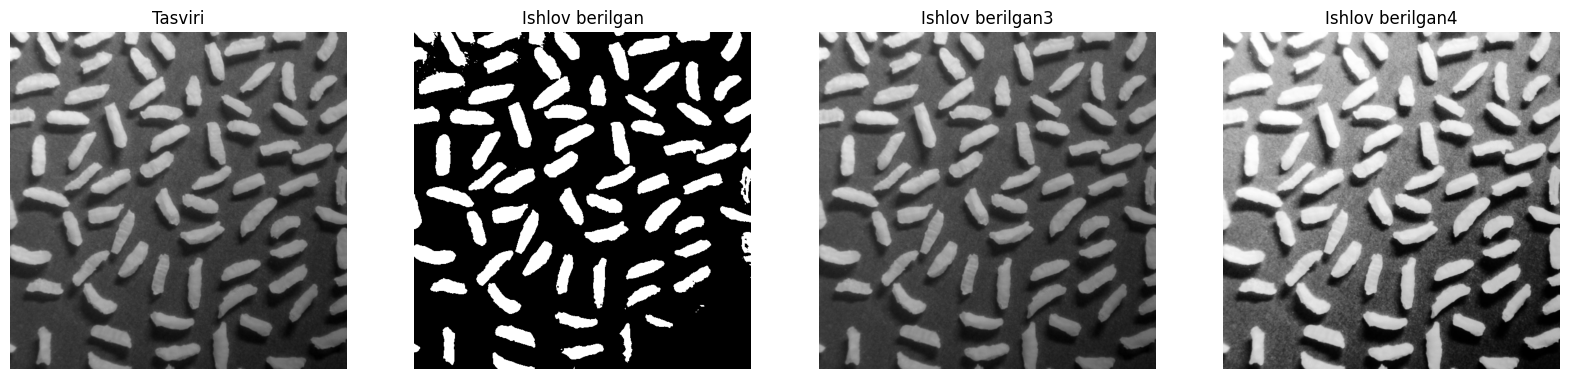

In [8]:
#IMpuls shovqini qo`shish va mediana filrt bilan ishlov berish
import numpy as np
import random
from PIL import Image, ImageDraw #Подключим необходимые библиотеки. 
import math

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np


import cv2 as cv
mu, sigma = 0, 0.1 # mean and standard deviation


f = Image.open("DIP3E_Original_Images_CH09/Fig0940(a)(rice_image_with_intensity_gradient).tif")
fnum=np.array(f)

fig = plt.figure(figsize=(20, 40))
rows, columns=(1,4)


fig.add_subplot(rows, columns, 1) 
plt.imshow(f, cmap='gray')
plt.axis('off')
plt.title("Tasviri")


params = {"K": 2, "I" : 100, "P" : 2, "THETA_M" : 10, "THETA_S" : 0.1,
          "THETA_C" : 4, "THETA_O" : 0.01}

# run Isodata

#fnum = equalization_using_histogram(fnum)
class_image = isodata_classification(fnum, parameters=params)
class_image_eq = equalization_using_histogram(class_image)

fig.add_subplot(rows, columns, 2) 
plt.imshow(class_image_eq, cmap='gray')
plt.axis('off')
plt.title("Ishlov berilgan")


fig.add_subplot(rows, columns, 3) 
plt.imshow(fnum, cmap='gray')
plt.axis('off')
plt.title("Ishlov berilgan3")


image_eq = equalization_using_histogram(fnum)

fig.add_subplot(rows, columns, 4) 
plt.imshow(image_eq, cmap='gray')
plt.axis('off')
plt.title("Ishlov berilgan4")

print("Hello")


In [9]:
import numpy as np
from scipy.cluster.vq import vq

# default number of clases
K_CLASSES = 5
# default number of iterations
ITER_MAX = 100


def initial_clusters(img_flat, k, method="random"):
    """Define initial clusters centers as startup.

    By default, the method is "linspace". Other method available is "random".

    """
    methods_availables = ["linspace", "random"]

    assert method in methods_availables, "ERROR: method {} is no valid." \
                                         "Methods availables {}" \
                                         % (method, methods_availables)
    if method == "linspace":
        max, min = img_flat.max(), img_flat.min()
        centers = np.linspace(min, max, k)
    elif method == "random":
        start, end = 0, img_flat.size
        indices = np.random.randint(start, end, k)
        centers = img_flat.take(indices)

    return centers


def update_centers(img_flat, img_class, centers):
    """Update the cluster center, computing the mean of all cluster members.

    """
    axis = 0
    n_clusters = centers.shape[0]
    for cluster in range(n_clusters):
        condition = np.equal(img_class, cluster)
        members = np.compress(condition, img_flat, axis)
        if members.shape[0] > 0:
            centers[cluster] = np.mean(members, axis)

    return centers


def converged_clusters(centers, last_centers, iter):
    """ Stop algorithm if there is no change in the clusters values between each
    iteration.

    Returns:
            - True if should stop, otherwise False.
    """
    return np.array_equiv(centers, last_centers)


def kmeans_classification(img, k=K_CLASSES, iter_max=ITER_MAX):
    """Classify a numpy 'image' according K-means algorithm.

    Parameters:
            - img: an input numpy array that contains the image to classify.
            - k: number of classes (if not setted will use 5 as default)
            - iter_max: maximum number of iterations (if not setted will use
              100 as default)

    Return value:
            - img_class: an numpy array image with the classification.

    """
    N, M = img.shape
    img_flat = img.flatten()

    centers = initial_clusters(img_flat, k, "linspace")

    for iter in range(0, iter_max):
        img_class, distances = vq(img_flat, centers)

        last_centers = centers.copy()
        centers = update_centers(img_flat, img_class, centers)

        if converged_clusters(centers, last_centers, iter):
            break

    print("Kmeans(info): Used {} classes.".format(k))
    print ("Kmeans(info): Number of Iterations done: {}".format(iter + 1))

    return img_class.reshape(N, M)

Kmeans(info): Used 2 classes.
Kmeans(info): Number of Iterations done: 5


Text(0.5, 1.0, 'K-mens equalization image')

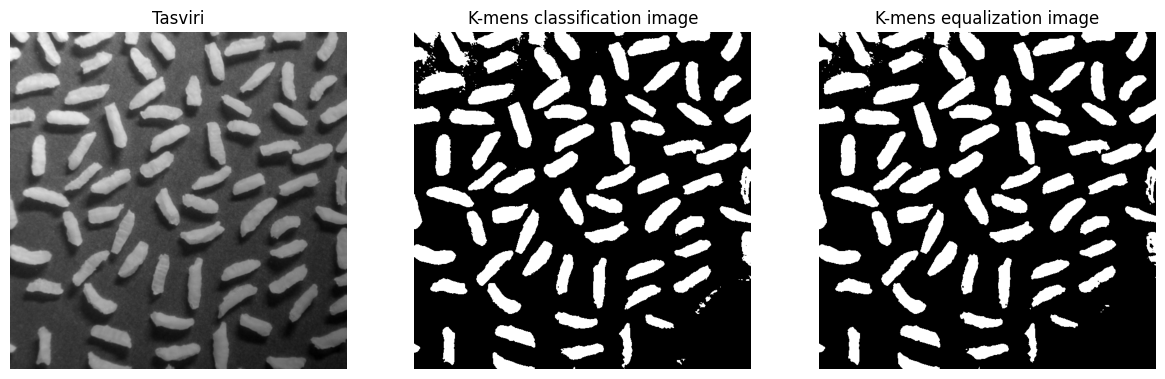

In [13]:
f = Image.open("DIP3E_Original_Images_CH09/Fig0940(a)(rice_image_with_intensity_gradient).tif")
fnum=np.array(f)

fig = plt.figure(figsize=(20, 40))
rows, columns=(1,4)


fig.add_subplot(rows, columns, 1) 
plt.imshow(f, cmap='gray')
plt.axis('off')
plt.title("Tasviri")


kmeans_class_image = kmeans_classification(fnum, k=2)

fig.add_subplot(rows, columns, 2) 
plt.imshow(kmeans_class_image, cmap='gray')
plt.axis('off')
plt.title("K-mens classification image")


class_image_eq = equalization_using_histogram(class_image)

fig.add_subplot(rows, columns, 3) 
plt.imshow(class_image_eq, cmap='gray')
plt.axis('off')
plt.title("K-mens equalization image")
